# Оглавление
* [Описание проекта](#chapter1)
* [Предобработка данных](#chapter2)
   * [Работа с дубликатами](#chapter3)
   * [Работа с пропусками](#chapter4)
* [Исследовательский анализ данных](#chapter5)
   * [Выявление грейда требуемых специалистов](#chapter6)
   * [Определение доли грейдов](#chapter7)
   * [Определение типичного места работы](#chapter8)
   * [Определение доли hard и soft навыков](#chapter9)
* [Общий вывод и рекомендации](#chapter10) 

## Описание проекта <a id="chapter1"></a>

Цель проекта: выявить различия в предлагаемых вакансиях для Аналитиков данных и Системных аналитиков среди вакансий, представленных на портале HH.ru.

Задачи:   
1.	Предобработка данных
2.	Исследовательский анализ данных
3.	Выявление грейда требуемых специалистов по названию вакансии или по колонке с требуемым опытом
4.	Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Системный Аналитик
5.	Определение типичного места работы для Аналитика Данных и Системного Аналитика по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы,
Ответ нужен для грейдов Junior, Junior+, Middle, Senior
6.	Определите, какие навыки спрашивают чаще hard или soft
7.	Определите наиболее желаемых кандидатов на вакансии Аналитика Данных и Системного Аналитика по следующим параметрам: самые важные hard-skills, cамые важные soft-skills. Ответ дайте отдельно для Junior, Junior+, Middle, Senior
8.	Формулировка выводов и рекомендаций 

Описание полей в данных
* id - Уникальный идентификатор вакансии.
* name - Название вакансии.
* published_at - Дата публикации.
* alternate_url - Ссылка на вакансию.
* type - Статус вакансии на момент получения данных от api и передачи
их в базу.
* employer - Работодатель.
* department - Работодатель, отдел.
* area - Регион места работы.
* experience - Требуемый опыт работы.
* key_skills - Ключевые навыки, в том числе найденные при анализе
полного текста вакансии. Поле генерируется после получения
информации от api.
* schedule - График работы.
* employment - Тип занятости.
* description - Описание вакансии.
* description_lemmatized - Лемматизированное описание вакансии.
* salary_from - Нижняя граница предлагаемой заработной платы.
* salary_to - Верхняя граница предлагаемой заработной платы.
* salary_bin - Категория зарплаты.
* key_skills_from_key_skills_field - Ключевые навыки из поля вакансии
key_skills.
* hard_skills_from_description - “Твердые” навыки, найденные при
обработке полей с навыками. Поле генерируется после получения
информации от api. soft_skills_from_description - “Мягкие” навыки,
найденные при обработке полей с навыками. Поле генерируется после
получения информации от api.

## Предобработка данных <a id="chapter2"></a>

In [1]:
#импортируем библиотеки
import pandas as pd
import requests
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
#читаем файлы
da = pd.read_excel(r"C:\Users\Guseva\Downloads\vacancies_da.xlsx")
sa = pd.read_excel(r"C:\Users\Guseva\Downloads\vacancies_sa.xlsx")

In [3]:
# устанавливаем максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', None)

# отключаем экспоненциальную форму чисел
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# функция которая выводит короткую справку о датасете
def brief(df):
    
        print(f"\nИнформация по датасету\n")
        
        print("Первые пять строк датафрейма:")
        display(df.head())
        print()
        
        print("Описательная статистика:")
        display(df.describe())
        print()
        
        print("Общая информация о датафрейме:")
        df.info()
        print()
        
        print(f"Количество явных дубликатов в датафрейме: {df.duplicated().sum()}")
        print()
        
        print("Процент пропущенных значений в столбцах:")
        for column in df.columns:
            missing_percentage = df[column].isna().mean() * 100
            if missing_percentage > 0:
                print(f"{column}: {missing_percentage:.2f}%")
       

In [5]:
brief(da)


Информация по датасету

Первые пять строк датафрейма:


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.00,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.00,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",Полный день,Полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,ЗП не указана,NaN,NaN,Документация



Описательная статистика:


,id,salary_from,salary_to
count,1801.00,348.00,228.00
mean,97226464.30,109525.09,153846.71
std,2894521.85,63011.34,97255.74
min,77992314.00,50.00,25000.00
25%,95448125.00,70000.00,85000.00
50%,97356356.00,90000.00,120000.00
75%,99425261.00,137750.00,200000.00
max,101746482.00,398000.00,497500.00



Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1801 non-null   int64         
 1   name                              1801 non-null   object        
 2   published_at                      1801 non-null   datetime64[ns]
 3   alternate_url                     1801 non-null   object        
 4   type                              1801 non-null   object        
 5   employer                          1801 non-null   object        
 6   department                        521 non-null    object        
 7   area                              1801 non-null   object        
 8   experience                        1801 non-null   object        
 9   key_skills                        1801 non-null   object        
 10  schedule        

In [6]:
brief(sa)


Информация по датасету

Первые пять строк датафрейма:


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,NaN,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",Полный день,Полная занятость,юрент — это новый уровень городской мобильност...,юрент новый уровень городской мобильность круп...,NaN,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,NaN
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",Удаленная работа,Полная занятость,в surf уже 13 лет мы разрабатываем много разны...,surf 13 год разрабатывать разный продукт начин...,NaN,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",NaN,Документация
2,100059559,Системный IT аналитик,2024-07-08 11:48:17,https://hh.ru/vacancy/100059559,Открытая,AMarkets,NaN,Москва,Junior+ (1-3 years),['Документация'],Полный день,Полная занятость,"мы - международная fintech компания amarkets, ...",международный fintech компания amarkets 2 7 го...,233750.00,NaN,ЗП не указана,NaN,NaN,Документация
3,100063260,Системный Аналитик ERP-решений,2024-07-09 10:51:54,https://hh.ru/vacancy/100063260,Открытая,Астор,NaN,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",Удаленная работа,Полная занятость,компания «астор» с 2000 года занимается разраб...,компания астор 2 год заниматься разработка вне...,NaN,NaN,ЗП не указана,"ERP, 1С: Управление Торговлей, Atlassian Jira,...",confluence,Коммуникация
4,100064793,Системный аналитик,2024-07-08 16:39:40,https://hh.ru/vacancy/100064793,Открытая,Зетта Страхование,NaN,Москва,Junior+ (1-3 years),"['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...",Полный день,Полная занятость,обязанности: анализ задач развития и сопрово...,обязанность анализ задача развитие сопровожден...,NaN,NaN,ЗП не указана,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",NaN,NaN



Описательная статистика:


,id,salary_from,salary_to
count,1915.00,356.00,279.00
mean,100107444.71,154117.59,223633.58
std,5214258.45,74335.13,103654.64
min,52410168.00,280.00,20000.00
25%,98814421.00,85000.00,145000.00
50%,102288353.00,150000.00,220000.00
75%,103131490.00,200000.00,300000.00
max,103584669.00,350000.00,580000.00



Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1915 non-null   int64         
 1   name                              1915 non-null   object        
 2   published_at                      1915 non-null   datetime64[ns]
 3   alternate_url                     1915 non-null   object        
 4   type                              1915 non-null   object        
 5   employer                          1915 non-null   object        
 6   department                        361 non-null    object        
 7   area                              1915 non-null   object        
 8   experience                        1915 non-null   object        
 9   key_skills                        1915 non-null   object        
 10  schedule        

На первый взгляд в представленных датасетах:
1. явных дубликатов не обнаружено,
2. типы данных соответствуют описанию,
3. названия столбцов соответствуют snake case и в обоих таблицах идентичны
4. больше всего пропусков в столбцах с зарплатными данными
5. меньше всего пропусков в таблице с вакансиями дата аналитиков в столбце с ключевыми навыками из описания, а в датасете с вакансиями системных аналитиков меньше всего пропусков в софт скиллах.
6. в статистической справке привлекают внимание минимальные значения зарплат в 50 рублей для дата аналитика и 280 рублей для системного аналитика.

In [7]:
#копируем таблицы, чтобы сохранить исходные данные
data_analysts = da.copy()
sistem_analysts = sa.copy()

Исследуем минимальные зарплаты аналитиков

In [8]:
data_analysts.query('salary_from < 20000')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1110,96943446,Аналитик данных в отдел развития на маркетплейсах,2024-05-11 21:45:07,https://hh.ru/vacancy/96943446,Открытая,Репетуев Иван Дмитриевич,NaN,Москва,Junior (no experince),"['Аналитическое мышление', 'Аналитика продаж',...",Удаленная работа,Полная занятость,ищу в команду аналитика до глубины мозга косте...,искать команда аналитик глубина мозг кость име...,50.00,100001.00,От 100 тысяч до 200 тысяч,"Аналитика продаж, Конкурентная аналитика, Анал...",NaN,NaN


[![2024-12-09_02-37-09.png](https://s.iimg.su/s/08/th_y9YLumKBq67pmCV3FNLuRYRy4E2iQ0yLVLM4jz9f.png)](https://iimg.su/i/yBkPm)

In [9]:
sistem_analysts.query('salary_from < 20000')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1470,91944373,Системный Аналитик Middle/Senior,2024-07-06 15:14:38,https://hh.ru/vacancy/91944373,Открытая,Datanomica,NaN,Москва,Senior (6+ years),"['JSON API', 'JSON', 'XML', 'SQL', 'Юнит-эконо...",Удаленная работа,Полная занятость,"привет! мы — ооо «датаномика», решаем проблемы...",привет датаномика решать проблема структуриров...,280.00,340000.00,Больше 300 тысяч,"JSON API, XML, JSON, Agile, Java, SQL, Kafka","confluence, Юнит-экономика",NaN


[![2024-12-09_02-31-41.png](https://s.iimg.su/s/08/th_G0wFNBNawmAV0fmBL2Vqv2aNgtxuZtEu8zjeMu6z.png)](https://iimg.su/i/NchqK)

Скорее всего имеют место опечатки, думаю, имелись в виду 50 тысяч и 280 тысяч рублей соответственно. 

In [10]:
data_analysts.loc[data_analysts['salary_from'] == 50 , 'salary_from'] = 50000
sistem_analysts.loc[sistem_analysts['salary_from'] == 280 , 'salary_from'] = 280000

display(sistem_analysts.query('id == 91944373'), 
      data_analysts.query('id == 96943446 ')
     )

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1470,91944373,Системный Аналитик Middle/Senior,2024-07-06 15:14:38,https://hh.ru/vacancy/91944373,Открытая,Datanomica,NaN,Москва,Senior (6+ years),"['JSON API', 'JSON', 'XML', 'SQL', 'Юнит-эконо...",Удаленная работа,Полная занятость,"привет! мы — ооо «датаномика», решаем проблемы...",привет датаномика решать проблема структуриров...,280000.00,340000.00,Больше 300 тысяч,"JSON API, XML, JSON, Agile, Java, SQL, Kafka","confluence, Юнит-экономика",NaN


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1110,96943446,Аналитик данных в отдел развития на маркетплейсах,2024-05-11 21:45:07,https://hh.ru/vacancy/96943446,Открытая,Репетуев Иван Дмитриевич,NaN,Москва,Junior (no experince),"['Аналитическое мышление', 'Аналитика продаж',...",Удаленная работа,Полная занятость,ищу в команду аналитика до глубины мозга косте...,искать команда аналитик глубина мозг кость име...,50000.00,100001.00,От 100 тысяч до 200 тысяч,"Аналитика продаж, Конкурентная аналитика, Анал...",NaN,NaN


In [11]:
data_analysts.nunique()

id                                  1801
name                                 763
published_at                        1746
alternate_url                       1801
type                                   1
employer                             690
department                            86
area                                  70
experience                             4
key_skills                           833
schedule                               4
employment                             4
description                         1460
description_lemmatized              1429
salary_from                           70
salary_to                             65
salary_bin                             5
key_skills_from_key_skills_field     774
hard_skills_from_description           8
soft_skills_from_description          35
dtype: int64

1. Все id и alternate_url уникальные
2. Много уникальных значений в столбцах: description, description_lemmatized, key_skills, key_skills_from_key_skills_field (39.31% пропусков в датасете), name, employer
3. Немного уникальных значений: type, department (71.07% пропусков в датасете), area, experience, schedule, employment, salary_from (80.68% пропусков), salary_to (87.34% пропусков), salary_bin, hard_skills_from_description(76.79% пропусков), soft_skills_from_description (67.35%)  

In [12]:
sistem_analysts.nunique()   

id                                  1915
name                                 813
published_at                        1766
alternate_url                       1915
type                                   1
employer                             836
department                            75
area                                  81
experience                             4
key_skills                          1080
schedule                               4
employment                             4
description                         1715
description_lemmatized              1696
salary_from                           54
salary_to                             57
salary_bin                             5
key_skills_from_key_skills_field    1032
hard_skills_from_description           4
soft_skills_from_description          29
dtype: int64

1. Все id и alternate_url уникальные
2. Много уникальных значений в столбцах: description, description_lemmatized, key_skills, key_skills_from_key_skills_field (33.47% пропусков в датасете), name, employer
3. Немного уникальных значений: type, department (81.15% пропусков в датасете), area, experience, schedule, employment, salary_from (81.41% пропусков), salary_to (85.43% пропусков), salary_bin, hard_skills_from_description(70.23% пропусков), soft_skills_from_description (25.48%)  

Посмотрим на уникальные значения столбцов:

In [13]:
def uniq_val(df):
    columns_to_check = [
        'type',
        'area',
        'experience',
        'schedule',
        'employment',
        'salary_from',
        'salary_to',
        'salary_bin',
        'hard_skills_from_description',
        'soft_skills_from_description'
    ]

    for column in columns_to_check:
        print(f"Столбец: {column}")
        print("Количество уникальных значений:", df[column].nunique())
        # Отображаем уникальные значения, отсортированные по возрастанию
        print("Уникальные значения:", sorted(df[column].dropna().unique()))
        print("-" * 50)

In [14]:
uniq_val(data_analysts)

Столбец: type
Количество уникальных значений: 1
Уникальные значения: ['Открытая']
--------------------------------------------------
Столбец: area
Количество уникальных значений: 70
Уникальные значения: ['Адыгейск', 'Алтайское', 'Артем', 'Байбек', 'Балашиха', 'Белгород', 'Вейделевка', 'Великие Луки', 'Вельск', 'Верхняя Пышма', 'Владивосток', 'Владимир', 'Волгоград', 'Воронеж', 'Горно-Алтайск', 'Дзержинский', 'Дмитров', 'Екатеринбург', 'Златоуст', 'Иваново (Ивановская область)', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Кемерово', 'Киров (Кировская область)', 'Королев', 'Краснодар', 'Красноярск', 'Курган', 'Липецк', 'Луховицы', 'Магнитогорск', 'Майкоп', 'Москва', 'Мытищи', 'Набережные Челны', 'Нефтекамск', 'Нижний Новгород', 'Новосибирск', 'Одинцово', 'Омск', 'Оренбург', 'Пермь', 'Подольск (Московская область)', 'Псков', 'Пушкино (Московская область)', 'Ростов-на-Дону', 'Рязань', 'Самара', 'Санкт-Петербург', 'Саратов', 'Северск (Томская область)', 'Симферополь', 'Смоленск', 'Сочи',

In [15]:
print("Самая ранняя дата публикации:", data_analysts['published_at'].min().date(), '\n' 
    "Самая поздняя дата публикации:", data_analysts['published_at'].max().date())

Самая ранняя дата публикации: 2024-02-13 
Самая поздняя дата публикации: 2024-06-11


In [16]:
uniq_val(sistem_analysts)

Столбец: type
Количество уникальных значений: 1
Уникальные значения: ['Открытая']
--------------------------------------------------
Столбец: area
Количество уникальных значений: 81
Уникальные значения: ['Абакан', 'Адлер', 'Апатиты', 'Астрахань', 'Барнаул', 'Белгород', 'Белорецк', 'Брянск', 'Владивосток', 'Владимир', 'Волгоград', 'Вологда', 'Воронеж', 'Геленджик', 'Дзержинск (Нижегородская область)', 'Дубна', 'Екатеринбург', 'Иваново (Ивановская область)', 'Ижевск', 'Иннополис', 'Иркутск', 'Йошкар-Ола', 'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров (Кировская область)', 'Кольчугино', 'Королев', 'Кострома', 'Красногорск', 'Краснодар', 'Красноярск', 'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Майкоп', 'Москва', 'Муром', 'Мытищи', 'Набережные Челны', 'Нижний Новгород', 'Новокузнецк', 'Новосибирск', 'Новочеркасск', 'Омск', 'Орел', 'Оренбург', 'Пенза', 'Пермь', 'Петрозаводск', 'Подольск (Московская область)', 'Ростов-на-Дону', 'Рубцовск', 'Рязань', 'Самара', 'Санкт-Петербург', 'Са

In [17]:
print("Самая ранняя дата публикации:", sistem_analysts['published_at'].min().date(), '\n' 
    "Самая поздняя дата публикации:", sistem_analysts['published_at'].max().date())

Самая ранняя дата публикации: 2024-06-27 
Самая поздняя дата публикации: 2024-07-09


### Работа с дубликатами  <a id="chapter3"></a>

In [18]:
data_analysts[data_analysts.duplicated(subset=['id'], keep=False)] \
.sort_values(by=['name', 'employer'])


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description


In [19]:
sistem_analysts[sistem_analysts.duplicated(subset=['id'], keep=False)] \
.sort_values(by=['name', 'employer'])

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description


Так как все id вакансий уникальные, посмотрим на дубликаты по всем столбцам, кроме id, ссылки и даты публикации.

In [20]:
columns_list = [
    'name', 
    'employer', 
    'department', 
    'area', 
    'experience'
]

In [21]:
data_analysts[data_analysts.duplicated(subset=columns_list)] \
.sort_values(by=['name', 'employer'])

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1439,98305174,BI-Аналитик/Бизнес-Аналитик/Аналитик данных,2024-05-12 10:03:19,https://hh.ru/vacancy/98305174,Открытая,Гоудрон,NaN,Москва,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Работа с большим объ...",Полный день,Полная занятость,"привет, уважаемые соискатели! мы, компания, &q...",привет уважаемый соискатель компания quot godr...,100000.00,NaN,ЗП не указана,"SQL, Аналитика, Анализ данных, Базы данных, Ра...",NaN,NaN
909,95919755,BI-аналитик / Data Analyst / Аналитик данных,2024-04-23 11:41:29,https://hh.ru/vacancy/95919755,Открытая,Федеральная сеть книжных магазинов Читай-город,NaN,Москва,Junior+ (1-3 years),"['MS SQL', 'Анализ данных', 'SQL', 'MS Excel']",Удаленная работа,Полная занятость,привет! мы команда ит компании &quot;читай тех...,привет команда ита компания quot читать технол...,NaN,NaN,ЗП не указана,"MS SQL, SQL, Анализ данных, MS Excel",NaN,NaN
1408,98088004,BI-аналитик/ Аналитик данных,2024-05-12 17:09:30,https://hh.ru/vacancy/98088004,Открытая,Сэлвим,NaN,Москва,Junior+ (1-3 years),['Pandas'],Полный день,Полная занятость,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN
1296,97631655,Data Analyst,2024-04-22 14:47:42,https://hh.ru/vacancy/97631655,Открытая,Finstar Financial Group,NaN,Москва,Junior+ (1-3 years),"['confluence', 'Python', 'Документация', 'SQL']",Полный день,Полная занятость,finstar financial group – крупный международны...,finstar financial group крупный международный ...,NaN,NaN,ЗП не указана,"Python, SQL",confluence,Документация
1793,99973972,Data Analyst,2024-05-23 16:28:59,https://hh.ru/vacancy/99973972,Открытая,Finstar Financial Group,NaN,Москва,Junior+ (1-3 years),"['confluence', 'Python', 'Документация', 'SQL']",Полный день,Полная занятость,finstar financial group – крупный международны...,finstar financial group крупный международный ...,187000.00,280500.00,От 200 тысяч до 300 тысяч,"Python, SQL",confluence,Документация
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,98390875,Старший аналитик данных (Data Scientist),2024-05-04 16:33:29,https://hh.ru/vacancy/98390875,Открытая,Газпром нефть,ПАО «Газпром нефть» ИТ,Санкт-Петербург,Junior+ (1-3 years),[],Полный день,Полная занятость,мы – команда «газпромнефть – цифровые решения»...,команда газпромнефть цифровой решение часть ит...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
1030,96494928,Старший аналитик данных (маркетинг),2024-04-09 09:38:57,https://hh.ru/vacancy/96494928,Открытая,Ozon,Ozon Офис и Коммерция,Москва,Middle (3-6 years),"['SQL', 'Python', 'Маркетинг, реклама, PR', 'М...",Удаленная работа,Полная занятость,чем предстоит заниматься: отслеживать и собир...,предстоять заниматься отслеживать собирать раз...,NaN,NaN,ЗП не указана,"Маркетинг, реклама, PR, аналитика данных, Pyth...",Pandas,NaN
1747,99737480,Урбан-аналитик данных,2024-06-08 17:13:09,https://hh.ru/vacancy/99737480,Открытая,Mayak,NaN,Москва,Junior+ (1-3 years),"['Английский язык', 'Анализ данных', 'Девелопм...",Полный день,Частичная занятость,обязанности: • анализ рынка/субрынков коммерче...,обязанность анализ рынок субрынок коммерческий...,100000.00,NaN,ЗП не указана,"Маркетинговый анализ, Английский язык, GIS, Та...",NaN,Тайм-менеджмент
1656,99141448,Эксперт по цифровым технологиям аудита (Data A...,2024-05-16 12:03:05,https://hh.ru/vacancy/99141448,Открытая,СБЕР,Сбер для экспертов,Санкт-Петербург,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Python', 'Hadoop', '...",Полный день,Полная занятость,приглашаем присоединиться к команде отдела ауд...,приглашать присоединяться команда отдел аудит ...,NaN,NaN,ЗП не указана,"SQL, Python, Hadoop, Анализ данных",NaN,Переговоры


In [22]:
len(data_analysts[data_analysts.duplicated(subset=columns_list)] \
.sort_values(by=['name', 'employer']))/ len(data_analysts)*100

21.654636313159354

Также и для системных аналитиков

In [23]:
sistem_analysts[sistem_analysts.duplicated(subset=columns_list)] \
.sort_values(by=['name', 'employer'])

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1012,103277921,System Analyst,2024-07-04 11:14:26,https://hh.ru/vacancy/103277921,Открытая,АТОМ,NaN,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,мы — атом. разрабатываем электромобиль-гаджет ...,атом разрабатывать электромобиль гаджет версия...,NaN,NaN,ЗП не указана,NaN,NaN,Документация
710,103031056,System Analyst / Системный аналитик,2024-07-01 10:52:04,https://hh.ru/vacancy/103031056,Открытая,Aston,NaN,Москва,Middle (3-6 years),"['Apache Kafka', 'REST', 'SQL', 'SOAP', 'UML',...",Полный день,Полная занятость,заказчик входит в топ-10 российских банков по ...,заказчик входить топ 1 российский банк величин...,NaN,NaN,ЗП не указана,"SQL, SOAP, REST, Apache Kafka, UML, BPMN",NaN,NaN
730,103039294,System Analyst / Системный аналитик,2024-07-01 12:09:36,https://hh.ru/vacancy/103039294,Открытая,Aston,NaN,Воронеж,Middle (3-6 years),['confluence'],Удаленная работа,Полная занятость,"мы – аутсорсинговая it-компания aston, разраба...",аутсорсинговый it компания aston разрабатывать...,NaN,NaN,ЗП не указана,NaN,confluence,NaN
991,103246914,System Analyst / Системный аналитик,2024-07-03 22:35:38,https://hh.ru/vacancy/103246914,Открытая,Aston,NaN,Санкт-Петербург,Junior+ (1-3 years),"['UML', 'Документация', 'REST', 'SQL']",Удаленная работа,Полная занятость,"мы – аутсорсинговая it-компания aston, разраба...",аутсорсинговый it компания aston разрабатывать...,NaN,NaN,ЗП не указана,"REST, UML, SQL",NaN,Документация
1680,96840588,System analyst / Системный аналитик,2024-07-05 16:01:02,https://hh.ru/vacancy/96840588,Открытая,АТОМ,NaN,Санкт-Петербург,Middle (3-6 years),['Документация'],Полный день,Полная занятость,мы — атом. разрабатываем электромобиль-гаджет ...,атом разрабатывать электромобиль гаджет версия...,NaN,NaN,ЗП не указана,NaN,NaN,Документация
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,102941659,Системный аналитик (кредитование),2024-06-28 17:56:00,https://hh.ru/vacancy/102941659,Открытая,СБЕР,Сбер. IT,Москва,Middle (3-6 years),['confluence'],Полный день,Полная занятость,команда трайба &quot;малый и микро бизнес&quot...,команда трайба quot малый микро бизнес quot ра...,NaN,NaN,ЗП не указана,NaN,confluence,NaN
1702,97290524,Системный аналитик 1С (Обучаем),2024-07-08 09:17:47,https://hh.ru/vacancy/97290524,Открытая,Компания Апогей (1С-франчайзи),NaN,Екатеринбург,Junior (no experince),[],Полный день,Полная занятость,системный аналитик 1с (обучаем) наши клиенты –...,системный аналитик 1с обучать наш клиент бухга...,40000.00,70000.00,Меньше 100 тысяч,NaN,NaN,NaN
156,101369907,Системный аналитик проекта по созданию и разви...,2024-07-03 13:08:49,https://hh.ru/vacancy/101369907,Открытая,Т1,ГК Иннотех | Большие данные,Москва,Middle (3-6 years),"['SQL', 'Анализ данных', 'Переговоры', 'Докуме...",Полный день,Полная занятость,​​​ищем энергичного системного-аналитика проек...,искать энергичный системный аналитик проект со...,NaN,NaN,ЗП не указана,"SQL, Проектная документация, Техническая докум...",NaN,"Документация, Проактивность, Переговоры"
82,101092259,Старший системный аналитик,2024-07-01 09:45:27,https://hh.ru/vacancy/101092259,Открытая,БФТ-Холдинг (Бюджетные и Финансовые Технологии),NaN,Москва,Middle (3-6 years),"['confluence', 'Документация']",Полный день,Полная занятость,бфт-холдинг (входит в группу компаний «ростеле...,бфт холдинг входить группа компания ростелеком...,NaN,NaN,ЗП не указана,NaN,confluence,Документация


In [24]:
len(sistem_analysts[sistem_analysts.duplicated(subset=columns_list)] \
.sort_values(by=['name', 'employer'])) / len(sistem_analysts)*100

4.073107049608355

Удалить 21% данных мы не можем. У системных аналитиков доля возможных дубликатов менее 5%, но даже в этом срезе содержаться ключевые данные для дальнейшего исследования (например зарплатные данные, доля пропусков в которых от 81% до 85%).
Поэтому пометим данные как возможные дубликаты. Будем считать, что дубликатами являются более "старые" по дате опубликования вакансии.

In [25]:
data_analysts = data_analysts.sort_values(by='published_at', ascending=False)

data_analysts['duplicates'] = data_analysts.duplicated(subset=columns_list, keep='first') \
.replace({True: 'возможный дубликат', False: ''})

data_analysts[data_analysts.duplicated(subset=columns_list, keep=False)] \
.sort_values(by=[
    'name', 
    'employer', 
    'department', 
    'area', 
    'experience'
])[[
    'published_at',
    'name', 
    'employer', 
    'department', 
    'area', 
    'experience', 
    'duplicates'
]].head(10)

,published_at,name,employer,department,area,experience,duplicates
215,2024-06-10 13:42:00,BI-Аналитик/Бизнес-Аналитик/Аналитик данных,Гоудрон,NaN,Москва,Junior+ (1-3 years),
1439,2024-05-12 10:03:19,BI-Аналитик/Бизнес-Аналитик/Аналитик данных,Гоудрон,NaN,Москва,Junior+ (1-3 years),возможный дубликат
228,2024-06-04 18:25:08,BI-аналитик / Data Analyst / Аналитик данных,Федеральная сеть книжных магазинов Читай-город,NaN,Москва,Junior+ (1-3 years),
909,2024-04-23 11:41:29,BI-аналитик / Data Analyst / Аналитик данных,Федеральная сеть книжных магазинов Читай-город,NaN,Москва,Junior+ (1-3 years),возможный дубликат
72,2024-06-09 10:00:29,BI-аналитик/ Аналитик данных,Сэлвим,NaN,Москва,Junior+ (1-3 years),
1408,2024-05-12 17:09:30,BI-аналитик/ Аналитик данных,Сэлвим,NaN,Москва,Junior+ (1-3 years),возможный дубликат
1793,2024-05-23 16:28:59,Data Analyst,Finstar Financial Group,NaN,Москва,Junior+ (1-3 years),
1296,2024-04-22 14:47:42,Data Analyst,Finstar Financial Group,NaN,Москва,Junior+ (1-3 years),возможный дубликат
1010,2024-04-14 12:06:20,Data Analyst,Finstar Financial Group,NaN,Москва,Junior+ (1-3 years),возможный дубликат
1728,2024-05-21 10:56:53,Data Analyst,INSITECH Development,NaN,Москва,Middle (3-6 years),


In [26]:
sistem_analysts = sistem_analysts.sort_values(by='published_at', ascending=False)

sistem_analysts['duplicates'] = sistem_analysts.duplicated(subset=columns_list, keep='first') \
.replace({True: 'возможный дубликат', False: ''})

sistem_analysts[sistem_analysts.duplicated(subset=columns_list, keep=False)] \
.sort_values(by=[
    'name', 
    'employer', 
    'department', 
    'area', 
    'experience'
])[[
    'published_at',
    'name', 
    'employer', 
    'department', 
    'area', 
    'experience', 
    'duplicates'
]].head(10)

,published_at,name,employer,department,area,experience,duplicates
206,2024-07-06 10:53:13,System Analyst,АТОМ,NaN,Москва,Middle (3-6 years),
1012,2024-07-04 11:14:26,System Analyst,АТОМ,NaN,Москва,Middle (3-6 years),возможный дубликат
252,2024-07-03 13:12:28,System Analyst / Системный аналитик,Aston,NaN,Воронеж,Middle (3-6 years),
730,2024-07-01 12:09:36,System Analyst / Системный аналитик,Aston,NaN,Воронеж,Middle (3-6 years),возможный дубликат
85,2024-07-03 11:18:11,System Analyst / Системный аналитик,Aston,NaN,Москва,Middle (3-6 years),
710,2024-07-01 10:52:04,System Analyst / Системный аналитик,Aston,NaN,Москва,Middle (3-6 years),возможный дубликат
991,2024-07-03 22:35:38,System Analyst / Системный аналитик,Aston,NaN,Санкт-Петербург,Junior+ (1-3 years),
512,2024-06-27 10:21:10,System Analyst / Системный аналитик,Aston,NaN,Санкт-Петербург,Junior+ (1-3 years),возможный дубликат
205,2024-07-06 10:53:09,System analyst / Системный аналитик,АТОМ,NaN,Санкт-Петербург,Middle (3-6 years),
1680,2024-07-05 16:01:02,System analyst / Системный аналитик,АТОМ,NaN,Санкт-Петербург,Middle (3-6 years),возможный дубликат


Можно выделить несколько возможных причин появления дубликатов вакансий:

**1. Разные названия для одной вакансии**        
Например, одна и та же позиция может быть названа по-разному: "Аналитик данных" и "Junior аналитик данных".     
Причина: Вакансия размещена разными рекрутерами, у которых нет единого стандарта наименования.    
**2. Повторная публикация**         
Компания может публиковать одну и ту же вакансию несколько раз, чтобы привлечь больше кандидатов.     
Причина: Повторные публикации для повышения видимости вакансии в поиске    
**3. Изменение условий или описания**         
Вакансии могут быть дублированы с изменением зарплаты, ключевых навыков, опыта или описания. 
Причина: Актуализация данных работодателем.         
**4. Разные рекрутеры или агентства**        
Один и тот же работодатель может поручить поиск сотрудников нескольким рекрутерам или агентствам.     
Причина: Делегирование найма внешним партнерам.    

Теперь, когда установили флаги возможных дубликатов, можно приступить к объединению таблиц, но для начала все же пометим датасеты отдельно.

In [27]:
data_analysts['dataset_type'] = 'da'
sistem_analysts['dataset_type'] ='sa'
display(data_analysts.head(), sistem_analysts.head())

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,duplicates,dataset_type
338,101746482,Дата аналитик,2024-06-11 15:07:30,https://hh.ru/vacancy/101746482,Открытая,RUTUBE,NaN,Москва,Middle (3-6 years),"['SQL', 'WEB аналитика', 'Clickhouse', 'Яндекс...",Полный день,Полная занятость,"rutube - крупнейший российский видеохостинг, г...",rutube крупный российский видеохостинг собират...,NaN,NaN,ЗП не указана,"SQL, WEB аналитика, Аналитическое мышление, Ян...",NaN,NaN,,da
1111,96969442,Аналитик данных в команду Рейнджеры (M+/S),2024-06-11 14:52:27,https://hh.ru/vacancy/96969442,Открытая,Контур,NaN,Екатеринбург,Middle (3-6 years),"['Power BI', 'Python', 'SQL', 'Математическое ...",Удаленная работа,Полная занятость,контур — экосистема продуктов для бизнеса. мы ...,контур экосистема продукт бизнес создавать реш...,NaN,NaN,ЗП не указана,"SQL, Python, Power BI, Математическое моделиро...",NaN,NaN,,da
1579,98824646,Аналитик данных в команду Обработки данных (Te...,2024-06-11 14:47:12,https://hh.ru/vacancy/98824646,Открытая,Контур,NaN,Екатеринбург,Middle (3-6 years),"['MS SQL', 'Анализ данных', 'Управление команд...",Удаленная работа,Полная занятость,команда состоит из разработчиков баз данных sq...,команда состоять разработчик база данные sql а...,NaN,NaN,ЗП не указана,"Написание документации для пользователей, Разр...",Pandas,Документация,,da
571,94290887,Ведущий аналитик данных (бизнес-аналитик),2024-06-11 14:36:37,https://hh.ru/vacancy/94290887,Открытая,Спортмастер,"Компания «СПОРТМАСТЕР», Логистика",Балашиха,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Power BI', 'Аналитик...",Полный день,Полная занятость,отдел отчетности и контроллинга приглашаем ана...,отдел отчетность контроллинг приглашать аналит...,NaN,NaN,ЗП не указана,"SQL, Базы данных, Аналитика, Аналитическое мыш...",NaN,NaN,,da
12,100080002,Продуктовый аналитик / Data Analyst,2024-06-11 14:34:15,https://hh.ru/vacancy/100080002,Открытая,Photo Lab,NaN,Москва,Junior+ (1-3 years),"['Linux', 'SQL', 'поведение пользователей', 'D...",Удаленная работа,Полная занятость,making mobile photo editing available to anyon...,making mobile photo editing available to anyon...,135000.00,185000.00,От 100 тысяч до 200 тысяч,"SQL, PostgreSQL, Python, MS Excel, LTV, AppsFl...",Pandas,NaN,,da


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,duplicates,dataset_type
1334,103584669,Системный аналитик (банковский проект),2024-07-09 12:47:11,https://hh.ru/vacancy/103584669,Открытая,Volna.tech,NaN,Санкт-Петербург,Middle (3-6 years),"['MS SQL', 'SQL', 'интеграции', 'Документация'...",Удаленная работа,Полная занятость,"itvolna.tech — мы быстрорастущая платформа, со...",itvolna tech быстрорастущий платформа создават...,NaN,330000.00,Больше 300 тысяч,"MS SQL, SQL, UML, BPMN, Системный анализ, инте...",NaN,Документация,,sa
235,101646657,Системный аналитик,2024-07-09 12:41:49,https://hh.ru/vacancy/101646657,Открытая,СберМаркетинг,NaN,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,чем предстоит заниматься: коммуницировать с з...,предстоять заниматься коммуницировать заказчик...,NaN,NaN,ЗП не указана,NaN,NaN,Документация,,sa
1333,103583874,Системный аналитик middle / senior удаленно,2024-07-09 12:38:43,https://hh.ru/vacancy/103583874,Открытая,MKomov Studio,NaN,Петрозаводск,Junior+ (1-3 years),"['Разработка технических заданий', 'Сбор требо...",Полный день,Полная занятость,mkomov studio — студия решения задач государст...,mkomov studio студия решение задача государств...,240000.00,280000.00,От 200 тысяч до 300 тысяч,"Системный анализ, BPMN, Разработка технических...",NaN,"Документация, Проактивность",,sa
1332,103583776,Системный аналитик,2024-07-09 12:37:22,https://hh.ru/vacancy/103583776,Открытая,Научно-Производственный Центр Макс,NaN,Москва,Middle (3-6 years),"['Внутренний аудит информационных систем', 'SW...",Полный день,Полная занятость,команда единомышленников создающая коробочные ...,команда единомышленник создавать коробочный пр...,NaN,NaN,ЗП не указана,"Бизнес-анализ, BPMN, SQL, IDEF3, Системный ана...",NaN,"Документация, Аналитическое мышление",,sa
437,102585796,Аналитик (системный),2024-07-09 12:37:06,https://hh.ru/vacancy/102585796,Открытая,SL Soft,NaN,Москва,Junior+ (1-3 years),"['Подготовка презентаций', 'SQL', 'Python', 'А...",Гибкий график,Полная занятость,сейчас мы активно ищем аналитиков в команду по...,активно искать аналитик команда разработка нов...,NaN,NaN,ЗП не указана,"SQL, Python, Аналитическое мышление, Подготовк...",NaN,NaN,,sa


In [28]:
#проверяем суммарную длину датасета перед объединением
len(data_analysts)+len(sistem_analysts)

3716

In [29]:
#объединяем датасеты
data = pd.concat([data_analysts, sistem_analysts] )
len(data)

3716

In [30]:
brief(data)


Информация по датасету

Первые пять строк датафрейма:


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,duplicates,dataset_type
338,101746482,Дата аналитик,2024-06-11 15:07:30,https://hh.ru/vacancy/101746482,Открытая,RUTUBE,NaN,Москва,Middle (3-6 years),"['SQL', 'WEB аналитика', 'Clickhouse', 'Яндекс...",Полный день,Полная занятость,"rutube - крупнейший российский видеохостинг, г...",rutube крупный российский видеохостинг собират...,NaN,NaN,ЗП не указана,"SQL, WEB аналитика, Аналитическое мышление, Ян...",NaN,NaN,,da
1111,96969442,Аналитик данных в команду Рейнджеры (M+/S),2024-06-11 14:52:27,https://hh.ru/vacancy/96969442,Открытая,Контур,NaN,Екатеринбург,Middle (3-6 years),"['Power BI', 'Python', 'SQL', 'Математическое ...",Удаленная работа,Полная занятость,контур — экосистема продуктов для бизнеса. мы ...,контур экосистема продукт бизнес создавать реш...,NaN,NaN,ЗП не указана,"SQL, Python, Power BI, Математическое моделиро...",NaN,NaN,,da
1579,98824646,Аналитик данных в команду Обработки данных (Te...,2024-06-11 14:47:12,https://hh.ru/vacancy/98824646,Открытая,Контур,NaN,Екатеринбург,Middle (3-6 years),"['MS SQL', 'Анализ данных', 'Управление команд...",Удаленная работа,Полная занятость,команда состоит из разработчиков баз данных sq...,команда состоять разработчик база данные sql а...,NaN,NaN,ЗП не указана,"Написание документации для пользователей, Разр...",Pandas,Документация,,da
571,94290887,Ведущий аналитик данных (бизнес-аналитик),2024-06-11 14:36:37,https://hh.ru/vacancy/94290887,Открытая,Спортмастер,"Компания «СПОРТМАСТЕР», Логистика",Балашиха,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Power BI', 'Аналитик...",Полный день,Полная занятость,отдел отчетности и контроллинга приглашаем ана...,отдел отчетность контроллинг приглашать аналит...,NaN,NaN,ЗП не указана,"SQL, Базы данных, Аналитика, Аналитическое мыш...",NaN,NaN,,da
12,100080002,Продуктовый аналитик / Data Analyst,2024-06-11 14:34:15,https://hh.ru/vacancy/100080002,Открытая,Photo Lab,NaN,Москва,Junior+ (1-3 years),"['Linux', 'SQL', 'поведение пользователей', 'D...",Удаленная работа,Полная занятость,making mobile photo editing available to anyon...,making mobile photo editing available to anyon...,135000.00,185000.00,От 100 тысяч до 200 тысяч,"SQL, PostgreSQL, Python, MS Excel, LTV, AppsFl...",Pandas,NaN,,da



Описательная статистика:


,id,salary_from,salary_to
count,3716.00,704.00,507.00
mean,98711146.07,132542.98,192250.14
std,4487851.76,72380.37,106554.77
min,52410168.00,20000.00,20000.00
25%,96159924.00,75000.00,100000.00
50%,99193958.50,120000.00,180000.00
75%,102375618.25,187000.00,280000.00
max,103584669.00,398000.00,580000.00



Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3716 entries, 338 to 22
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3716 non-null   int64         
 1   name                              3716 non-null   object        
 2   published_at                      3716 non-null   datetime64[ns]
 3   alternate_url                     3716 non-null   object        
 4   type                              3716 non-null   object        
 5   employer                          3716 non-null   object        
 6   department                        882 non-null    object        
 7   area                              3716 non-null   object        
 8   experience                        3716 non-null   object        
 9   key_skills                        3716 non-null   object        
 10  schedule        

Типы данных не изменились, новых явных дубликатов после объединения не появилось.

### Работа с пропусками  <a id="chapter4"></a>

Начнем с пропусков в колонках с навыками, рассмотрим какие есть скиллы и как часто они встречаются:

In [31]:
# с помощью функции переведем все значения в нижний регистр, удалим лишние пробелы, если они есть
def columns_low(data, columns):
    for column in columns:
        data[column] = data[column].apply(
            lambda x: x.lower().strip() if isinstance(x, str) and pd.notna(x) 
            else x  # Если значение не строка или NaN, оставляем без изменений
        )
    return data

In [32]:
list_col= ['soft_skills_from_description', 
           'hard_skills_from_description', 
           'key_skills_from_key_skills_field',
           'name',
           'employer'
          ]
data = columns_low(data, list_col)
data.head()

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,duplicates,dataset_type
338,101746482,дата аналитик,2024-06-11 15:07:30,https://hh.ru/vacancy/101746482,Открытая,rutube,NaN,Москва,Middle (3-6 years),"['SQL', 'WEB аналитика', 'Clickhouse', 'Яндекс...",Полный день,Полная занятость,"rutube - крупнейший российский видеохостинг, г...",rutube крупный российский видеохостинг собират...,NaN,NaN,ЗП не указана,"sql, web аналитика, аналитическое мышление, ян...",NaN,NaN,,da
1111,96969442,аналитик данных в команду рейнджеры (m+/s),2024-06-11 14:52:27,https://hh.ru/vacancy/96969442,Открытая,контур,NaN,Екатеринбург,Middle (3-6 years),"['Power BI', 'Python', 'SQL', 'Математическое ...",Удаленная работа,Полная занятость,контур — экосистема продуктов для бизнеса. мы ...,контур экосистема продукт бизнес создавать реш...,NaN,NaN,ЗП не указана,"sql, python, power bi, математическое моделиро...",NaN,NaN,,da
1579,98824646,аналитик данных в команду обработки данных (te...,2024-06-11 14:47:12,https://hh.ru/vacancy/98824646,Открытая,контур,NaN,Екатеринбург,Middle (3-6 years),"['MS SQL', 'Анализ данных', 'Управление команд...",Удаленная работа,Полная занятость,команда состоит из разработчиков баз данных sq...,команда состоять разработчик база данные sql а...,NaN,NaN,ЗП не указана,"написание документации для пользователей, разр...",pandas,документация,,da
571,94290887,ведущий аналитик данных (бизнес-аналитик),2024-06-11 14:36:37,https://hh.ru/vacancy/94290887,Открытая,спортмастер,"Компания «СПОРТМАСТЕР», Логистика",Балашиха,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Power BI', 'Аналитик...",Полный день,Полная занятость,отдел отчетности и контроллинга приглашаем ана...,отдел отчетность контроллинг приглашать аналит...,NaN,NaN,ЗП не указана,"sql, базы данных, аналитика, аналитическое мыш...",NaN,NaN,,da
12,100080002,продуктовый аналитик / data analyst,2024-06-11 14:34:15,https://hh.ru/vacancy/100080002,Открытая,photo lab,NaN,Москва,Junior+ (1-3 years),"['Linux', 'SQL', 'поведение пользователей', 'D...",Удаленная работа,Полная занятость,making mobile photo editing available to anyon...,making mobile photo editing available to anyon...,135000.00,185000.00,От 100 тысяч до 200 тысяч,"sql, postgresql, python, ms excel, ltv, appsfl...",pandas,NaN,,da


In [33]:
data['soft_skills_from_description'].value_counts()

документация                                                                        1168
коммуникация, документация                                                           213
коммуникация                                                                         175
аналитическое мышление                                                               148
документация, аналитическое мышление                                                  89
проактивность                                                                         33
документация, проактивность                                                           29
документация, переговоры                                                              22
коммуникация, документация, аналитическое мышление                                    15
проактивность, аналитическое мышление                                                 15
коммуникация, проактивность                                                           10
коммуникация, аналити

Список уникальных значений из столбца soft_skills_from_description содержит строки, в которых навыки объединены через запятую. Чтобы работать с каждым навыком отдельно, можно "взорвать" (разделить) эти строки, удалить дубликаты и получить список уникальных навыков из столбца.

In [34]:
soft_skills = list(
    data['soft_skills_from_description']
    .dropna()  # Удаляем NaN
    .str.split(', ')  # Разделяем строки по запятой и пробелу
    .explode()  # Взрываем списки в отдельные строки
    .str.strip()  # Удаляем лишние пробелы
    .unique()  # Извлекаем уникальные значения
)
soft_skills

['документация',
 'аналитическое мышление',
 'коммуникация',
 'решение проблем',
 'принятие решений',
 'проактивность',
 'креативность',
 'адаптивность',
 'тайм-менеджмент',
 'переговоры',
 'эмпатия',
 'критическое мышление',
 'внимание к деталям',
 'презентация результатов',
 'письменная коммуникация']

Поступим также с хард скилами и с ключевыми навыками, для чего напишем функцию:

In [35]:
def get_uniq_vals(data, column):
 
    uniq_vals = sorted(
                data[column]
                .dropna()  # Удаляем NaN
                .str.split(',')  # Разделяем строки по запятой и пробелу
                .explode()  # Взрываем списки в отдельные строки
                .str.strip()  # Удаляем лишние пробелы
                .unique()  # Извлекаем уникальные значения
                .tolist()  # Преобразуем в список
            )
        
    return uniq_vals

#сразу проверяем функцию
hard_skills = get_uniq_vals(data, 'hard_skills_from_description')
hard_skills

['confluence',
 'google sheets',
 'pandas',
 'математическая статистика',
 'юнит-экономика']

In [36]:
key_skills_list = get_uniq_vals(data, 'key_skills_from_key_skills_field')
key_skills_list

['.net',
 '.net core',
 '.net framework',
 '199-и',
 '1c',
 '1c ка',
 '1c кадры и бухгалтерия',
 '1c ух',
 '1c: erp',
 '1c: предприятие',
 '1с',
 '1с 8.0',
 '1с 8.3',
 '1с erp',
 '1с erp битфинанс',
 '1с erp)',
 '1с бп',
 '1с программирование',
 '1с ут 11',
 '1с ут11',
 '1с-битрикс',
 '1с:',
 '1с: erp',
 '1с: erp управление предприятием',
 '1с: бит финанс',
 '1с: бухгалтерия',
 '1с: бухгалтерия и склад',
 '1с: документооборот',
 '1с: зарплата и кадры',
 '1с: зарплата и управление персоналом',
 '1с: комплексная автоматизация',
 '1с: логистика',
 '1с: предприятие',
 '1с: предприятие 8',
 '1с: предприятие: розница',
 '1с: предприятие: управление строительной организацией',
 '1с: розница',
 '1с: торговля',
 '1с: торговля и склад',
 '1с: управление предприятием',
 '1с: управление производственным предприятием',
 '1с: управление торговлей',
 '1с: управление холдингом',
 '1с: фгис меркурий',
 '1с:erp',
 '1с:тоир',
 '223-фз',
 '3624-у',
 '3gpp',
 '44-фз',
 '483-п',
 '646-п',
 'a/b тестирование

Сохраним список ключевых навыков, обработаем их вручную в excel, разделив на hard и soft

In [37]:
ks = key_skills_list
ks = pd.DataFrame(ks)
ks.to_excel('key_skills.xlsx', index=False)

In [38]:
skills_data = pd.read_excel("C:/Users/Guseva/Downloads/key_skills.xlsx")
skills_data.head()

,skill,skill_type
0,.net,hard
1,.net core,hard
2,.net framework,hard
3,199-и,hard
4,1c,hard


In [39]:
# разделение навыков на hard и soft
hard_skills = set(skills_data[skills_data['skill_type'] == 'hard']['skill'])
soft_skills = set(skills_data[skills_data['skill_type'] == 'soft']['skill'])

def update_skills(row):
    # существующие значения в колонках описания
    existing_hard = set(str(row['hard_skills_from_description']).split(', ')) if pd.notna(row['hard_skills_from_description']) else set()
    existing_soft = set(str(row['soft_skills_from_description']).split(', ')) if pd.notna(row['soft_skills_from_description']) else set()

    # навыки из столбца key_skills_from_key_skills_field
    skills = set(str(row['key_skills_from_key_skills_field']).split(', '))

    # определение hard и soft навыков
    hard_to_add = skills & hard_skills
    soft_to_add = skills & soft_skills

    # обновление колонок
    if hard_to_add or existing_hard:
        row['hard_skills_from_description'] = ', '.join(sorted(existing_hard | hard_to_add))
    else:
        row['hard_skills_from_description'] = pd.NA

    if soft_to_add or existing_soft:
        row['soft_skills_from_description'] = ', '.join(sorted(existing_soft | soft_to_add))
    else:
        row['soft_skills_from_description'] = pd.NA

    return row

# применение функции для обновления датасета
data = data.apply(update_skills, axis=1)

In [40]:
data.head()

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,duplicates,dataset_type
338,101746482,дата аналитик,2024-06-11 15:07:30,https://hh.ru/vacancy/101746482,Открытая,rutube,NaN,Москва,Middle (3-6 years),"['SQL', 'WEB аналитика', 'Clickhouse', 'Яндекс...",Полный день,Полная занятость,"rutube - крупнейший российский видеохостинг, г...",rutube крупный российский видеохостинг собират...,NaN,NaN,ЗП не указана,"sql, web аналитика, аналитическое мышление, ян...","clickhouse, sql, web аналитика, яндекс.метрика",аналитическое мышление,,da
1111,96969442,аналитик данных в команду рейнджеры (m+/s),2024-06-11 14:52:27,https://hh.ru/vacancy/96969442,Открытая,контур,NaN,Екатеринбург,Middle (3-6 years),"['Power BI', 'Python', 'SQL', 'Математическое ...",Удаленная работа,Полная занятость,контур — экосистема продуктов для бизнеса. мы ...,контур экосистема продукт бизнес создавать реш...,NaN,NaN,ЗП не указана,"sql, python, power bi, математическое моделиро...","power bi, python, sql, математическое моделиро...",<NA>,,da
1579,98824646,аналитик данных в команду обработки данных (te...,2024-06-11 14:47:12,https://hh.ru/vacancy/98824646,Открытая,контур,NaN,Екатеринбург,Middle (3-6 years),"['MS SQL', 'Анализ данных', 'Управление команд...",Удаленная работа,Полная занятость,команда состоит из разработчиков баз данных sq...,команда состоять разработчик база данные sql а...,NaN,NaN,ЗП не указана,"написание документации для пользователей, разр...","ms sql, pandas, python, анализ данных, написан...","аналитическое мышление, документация, управлен...",,da
571,94290887,ведущий аналитик данных (бизнес-аналитик),2024-06-11 14:36:37,https://hh.ru/vacancy/94290887,Открытая,спортмастер,"Компания «СПОРТМАСТЕР», Логистика",Балашиха,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Power BI', 'Аналитик...",Полный день,Полная занятость,отдел отчетности и контроллинга приглашаем ана...,отдел отчетность контроллинг приглашать аналит...,NaN,NaN,ЗП не указана,"sql, базы данных, аналитика, аналитическое мыш...","power bi, sql, tableau, анализ данных, аналити...",аналитическое мышление,,da
12,100080002,продуктовый аналитик / data analyst,2024-06-11 14:34:15,https://hh.ru/vacancy/100080002,Открытая,photo lab,NaN,Москва,Junior+ (1-3 years),"['Linux', 'SQL', 'поведение пользователей', 'D...",Удаленная работа,Полная занятость,making mobile photo editing available to anyon...,making mobile photo editing available to anyon...,135000.00,185000.00,От 100 тысяч до 200 тысяч,"sql, postgresql, python, ms excel, ltv, appsfl...","airflow, apple search ads, appsflyer, b2c, das...",<NA>,,da


In [41]:
def losses(df): 
    for column in df.columns:
        missing_percentage = df[column].isna().mean() * 100
        if missing_percentage > 0:
            print(f"{column}: {missing_percentage:.2f}%")
            

In [42]:
losses(data)

department: 76.26%
salary_from: 81.05%
salary_to: 86.36%
key_skills_from_key_skills_field: 36.30%
hard_skills_from_description: 26.88%
soft_skills_from_description: 38.75%


Количество пропусков в навыках существенно сократилось, но все же % пропусков достаточно велик. Заполним оставшиеся пропуски маркером.

In [43]:
data[['hard_skills_from_description', 
      'soft_skills_from_description'
     ]]= data[[
    'hard_skills_from_description', 
    'soft_skills_from_description'
     ]].fillna('информация неизвестна')

In [44]:
data['hard_skills_from_description'].value_counts().head()

информация неизвестна                    999
confluence                               231
pandas                                   103
python, sql                               37
bpmn, kafka, rabbitmq, rest, sql, uml     16
Name: hard_skills_from_description, dtype: int64

In [45]:
data['soft_skills_from_description'].value_counts().head()

информация неизвестна                   1440
документация                            1014
аналитическое мышление                   239
документация, коммуникация               175
аналитическое мышление, документация     146
Name: soft_skills_from_description, dtype: int64

In [46]:
# получим топ-5 наборов навыков для дата-аналитиков
da_hard_top = data.query('dataset_type == "da"')['hard_skills_from_description'].value_counts().head()
da_soft_top = data.query('dataset_type == "da"')['soft_skills_from_description'].value_counts().head()

# получим топ-5 наборов навыков для системных аналитиков
sa_hard_top = data.query('dataset_type == "sa"')['hard_skills_from_description'].value_counts().head()
sa_soft_top = data.query('dataset_type == "sa"')['soft_skills_from_description'].value_counts().head()

print("Топ 5 наборов навыков для дата-аналитиков:")
print("-" * 40)
print("Хард скиллы:")
print(da_hard_top)
print("\nСофт скиллы:")
print(da_soft_top)

print("\nТоп 5 наборов навыков для системных аналитиков:")
print("-" * 40)
print("Хард скиллы:")
print(sa_hard_top)
print("\nСофт скиллы:")
print(sa_soft_top)

Топ 5 наборов навыков для дата-аналитиков:
----------------------------------------
Хард скиллы:
информация неизвестна    561
pandas                   102
python, sql               37
confluence                30
sql                       13
Name: hard_skills_from_description, dtype: int64

Софт скиллы:
информация неизвестна                   1020
аналитическое мышление                   183
документация                             181
коммуникация                              84
аналитическое мышление, документация      27
Name: soft_skills_from_description, dtype: int64

Топ 5 наборов навыков для системных аналитиков:
----------------------------------------
Хард скиллы:
информация неизвестна                                                                                                                                                                                                                                                                                                         

Теперь займемся пропусками в зарплатах. Обратимся к столбцу salary_bin

In [47]:
data['salary_bin'].value_counts()

ЗП не указана                3209
От 100 тысяч до 200 тысяч     171
От 200 тысяч до 300 тысяч     117
Больше 300 тысяч              110
Меньше 100 тысяч              109
Name: salary_bin, dtype: int64

Данных с неуказанными зарплатами существенно больше. Рассмотрим сможем ли мы что-то сделать для заполнения пропусков зарплатных столбцах.

In [48]:
data.query('salary_bin == "ЗП не указана"')[['salary_from', 'salary_to']].head(10)

,salary_from,salary_to
338,NaN,NaN
1111,NaN,NaN
1579,NaN,NaN
571,NaN,NaN
246,150000.00,NaN
11,350000.00,NaN
23,NaN,NaN
1736,NaN,NaN
146,NaN,NaN
1632,100000.00,NaN


In [49]:
data.query('salary_bin == "ЗП не указана"')['salary_to'].unique()

array([nan])

Получается, что по самому важному показателю - верхней планке зарплатных предложений мы не сможем скорректировать данные. Поэтому для дальнейшего исследования в разрезе зарплат будем опираться на столбец salary_bin

## Исследовательский анализ данных <a id='chapter5'></a>

### Выявление грейда требуемых специалистов <a id='chapter6'></a>

Для исследовательского анализа отсечем возможные дубликаты.

In [56]:
data = data.loc[data['duplicates'] != 'возможный дубликат']

In [96]:
grade = data.pivot_table(index='dataset_type', columns='experience', values='id', aggfunc='count' )
grade

experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
dataset_type,,,,
da,120,851,430,10
sa,85,828,880,44


### Определение доли грейдов<a id='chapter7'></a>

In [58]:
grade_ratio = grade.reset_index().set_index('dataset_type')
grade_ratio.columns = ['junior', 'junior+', 'middle', 'senior']
grade_ratio['total'] = grade_ratio['junior'] + grade_ratio['junior+'] + grade_ratio['middle'] + grade_ratio['senior']
grade_ratio['junior_ratio'] = grade_ratio['junior'] / grade_ratio['total'] * 100
grade_ratio['junior+_ratio'] = grade_ratio['junior+'] / grade_ratio['total'] * 100
grade_ratio['middle_ratio'] = grade_ratio['middle'] / grade_ratio['total'] * 100
grade_ratio['senior_ratio'] = grade_ratio['senior'] / grade_ratio['total'] * 100
grade_ratio = grade_ratio[['junior_ratio', 'junior+_ratio', 'middle_ratio', 'senior_ratio']]
grade_ratio 

,junior_ratio,junior+_ratio,middle_ratio,senior_ratio
dataset_type,,,,
da,8.50,60.31,30.47,0.71
sa,4.63,45.07,47.90,2.40


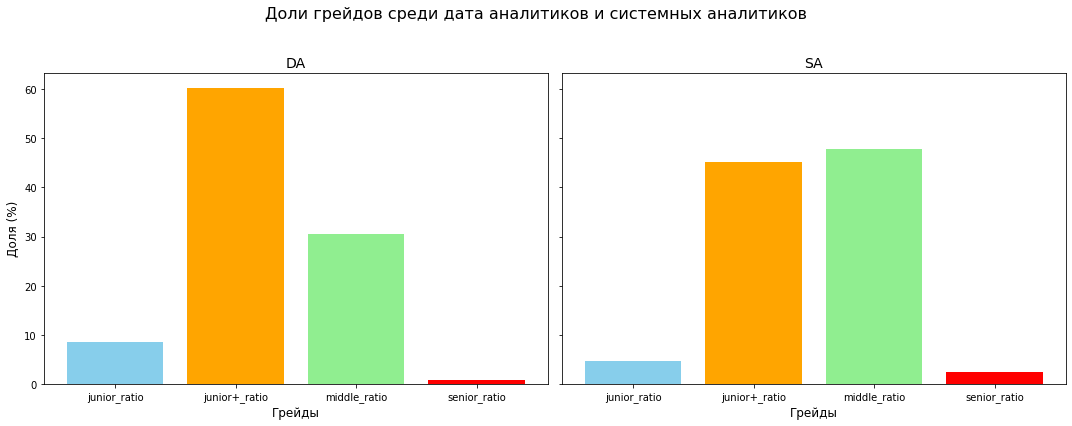

In [97]:
# Категории для визуализации
categories = grade_ratio.columns

# Создание подграфиков (sublots)
fig, axes = plt.subplots(1, len(grade_ratio), figsize=(15, 6), sharey=True)

# Построение графиков для каждого типа набора данных
for i, (dataset, row) in enumerate(grade_ratio.iterrows()):
    axes[i].bar(categories, row, color=['skyblue', 'orange', 'lightgreen', 'red'])
    axes[i].set_title(f'{dataset.upper()}', fontsize=14)
    axes[i].set_xlabel('Грейды', fontsize=12)
    axes[i].set_xticks(range(len(categories)))
    axes[i].set_xticklabels(categories)
    if i == 0:  # Для первого графика добавить подпись оси Y
        axes[i].set_ylabel('Доля (%)', fontsize=12)

# Общий заголовок
fig.suptitle('Доли грейдов среди дата аналитиков и системных аналитиков', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Показ графиков
plt.show()

Среди представленных вакансий наблюдается большее количество запросов на специалистов уровня junior+ и middle, как среди дата аналитиков, так и среди системных аналитиков. Но все же среди системных аналитиков чуть чаще нужны мидлы, а среди дата аналитиков количество запросов на junior+ существенно превалирует.

### Определение типичного места работы<a id="chapter8"></a>

In [60]:
def top_employers(data, dataset_type):
 
    # фильтруем данные по dataset_type
    filtered_data = data[data['dataset_type'] == dataset_type]
    
    # уровни грейдов
    grades = ['Junior', 'Junior+', 'Middle', 'Senior']
    
    # создаём сабплоты
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, grade in enumerate(grades):
        # фильтрация данных по каждому грейду
        grade_data = filtered_data[filtered_data['experience'].str.contains(grade, na=False)]
        
        # группировка данных по работодателям и подсчёт количества публикаций
        top_employers = grade_data['employer'].value_counts().head()
        
        # построение барплота
        axes[i].barh(top_employers.index, top_employers.values, color='skyblue')
        axes[i].set_title(f' Топ-5 работадателей для {grade} ({dataset_type.upper()})', fontsize=12)
        axes[i].set_xlabel('Количество вакансий', fontsize=10)
        axes[i].set_ylabel('Работодатели', fontsize=10)
        axes[i].invert_yaxis()  # инвертируем ось y для лучшей читаемости
    
    # общий заголовок и настройка визуализации
    fig.suptitle(f'Топ-5 работодателей для {dataset_type.upper()}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


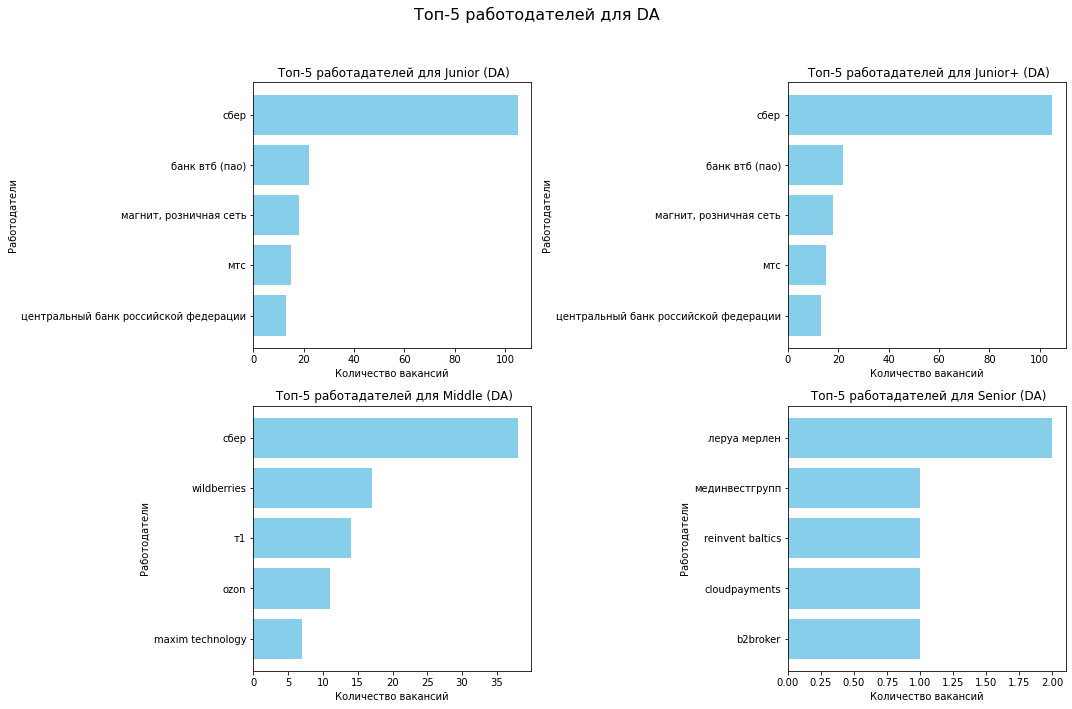

In [61]:
top_employers(data, dataset_type='da')

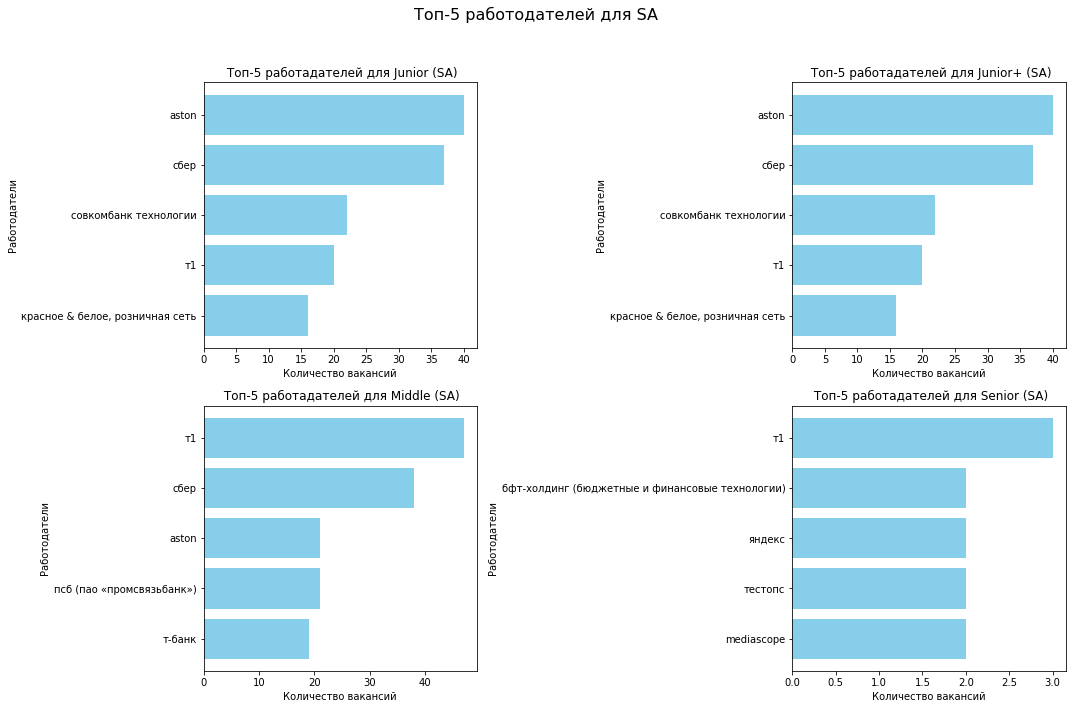

In [62]:
top_employers(data, dataset_type='sa')

Дата аналитиков уровня jun, jun+, middle активнее всего ищет сбер, а самые опытные специалисты среди аналитиков данных требуются в леруа мерлен.
Начинающих системных аналитиков практически одинаково ищут в aston и сбере, специалистов уровня middle и senior в т1.

In [88]:
# функция построения визуализации распределения значений в столбце в процентном отношениия для каждого грейда и типа специалиста
# относительно количества всех вакансий отдельно для дата аналитиков и системных аналитиков

def distribution(data, column, title_prefix):

    # уровни грейдов
    grades = ['Junior', 'Junior+', 'Middle', 'Senior']
    
    #специализация
    dataset_types = ['da', 'sa']
    colors = {'da': 'skyblue', 'sa': 'lightgreen'}
    
    # создаём сабплоты
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, grade in enumerate(grades):
        ax = axes[i]
        height = 0.4  # высота столбцов
        
        # словарь для хранения распределений по каждому типу специалистов
        distributions = {}
        
        for dataset_type in dataset_types:
            # фильтруем данные по грейду и типу
            filtered_data = data[(data['dataset_type'] == dataset_type) &
                                 (data['experience'].str.contains(grade, na=False))]
            
            # расчёт процента от общего числа записей для данного грейда и типа
            total_count = len(filtered_data)
            if total_count > 0:  # проверяем, чтобы избежать деления на 0
                distribution = (filtered_data[column].value_counts() / total_count) * 100
            else:
                distribution = pd.Series(dtype=float)
            
            distributions[dataset_type] = distribution
        
        # формируем общий список меток (категорий)
        categories = list(set(distributions['da'].index).union(set(distributions['sa'].index)))
        categories.sort()
        
        # индексы для категорий
        y = np.arange(len(categories))
        
        # построение столбцов для каждого типа специалистов
        for j, dataset_type in enumerate(dataset_types):
            values = [distributions[dataset_type].get(category, 0) for category in categories]
            ax.barh(y + j * height, values, height=height, label=f'{dataset_type.upper()}', color=colors[dataset_type])
        
        # настройка графика
        ax.set_title(f'{title_prefix} для {grade}', fontsize=12)
        ax.set_yticks(y + height / 2)
        ax.set_yticklabels(categories)
        ax.set_xlabel('Доля (%)', fontsize=10)
        ax.set_ylabel(column.replace('_', ' ').capitalize(), fontsize=10)
        ax.legend()

    # общий заголовок и настройка визуализации
    fig.suptitle(f'{title_prefix} в процентном отношении для DA и SA', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

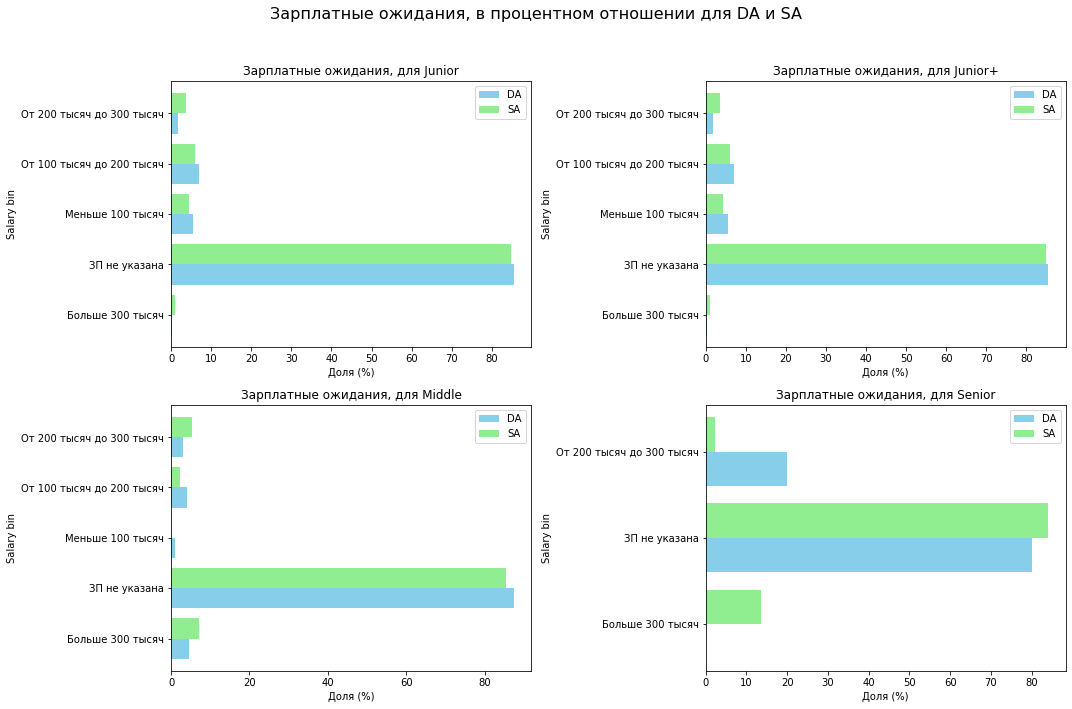

In [85]:
distribution(data, column='salary_bin', title_prefix='Зарплатные ожидания,')

Среди всех специалистов значительно превалируют вакансии с неуказанными данными по зарплатам, вне зависимости от грейда или направления деятельности. Скорее всего так компании могут устанавливать зарплатные рамки в зависимости от определенной кандидатуры.

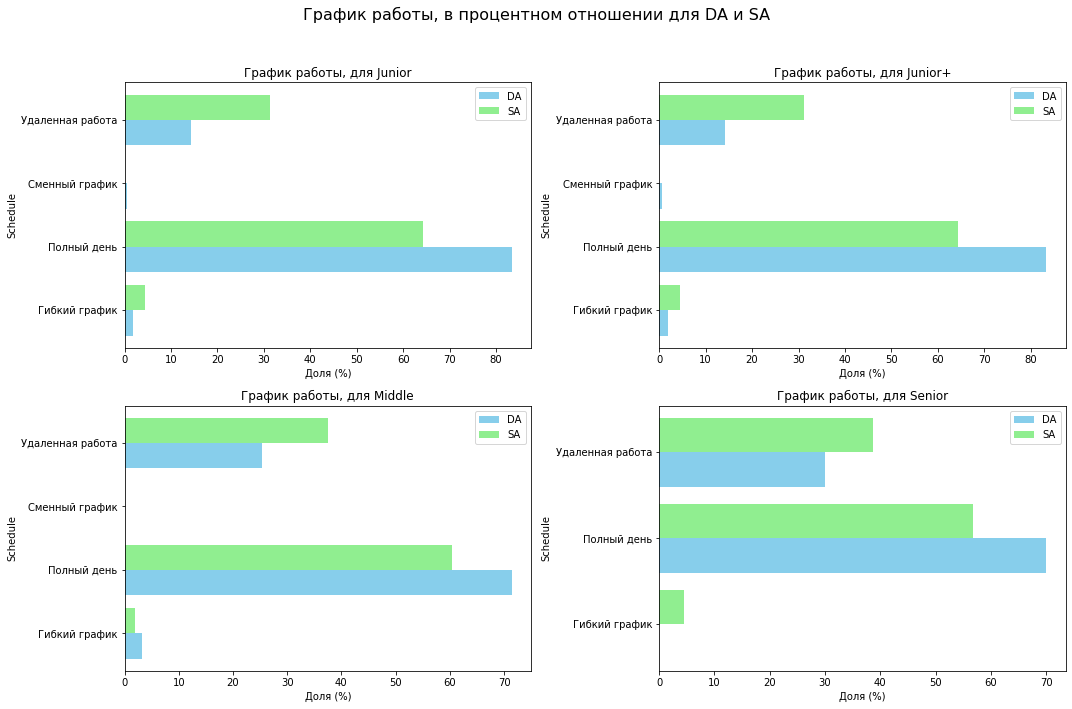

In [86]:
distribution(data, column='schedule', title_prefix='График работы,')


От специалистов всех уровней работодатели ждут устройства на полный рабочий день, но удаленную работу с большей вероятностью предложат соискателям на должность системного аналитика уровней middle и senior.
Относительно системных аналитиков, у дата аналитика шанс получить удаленную работу - ниже.

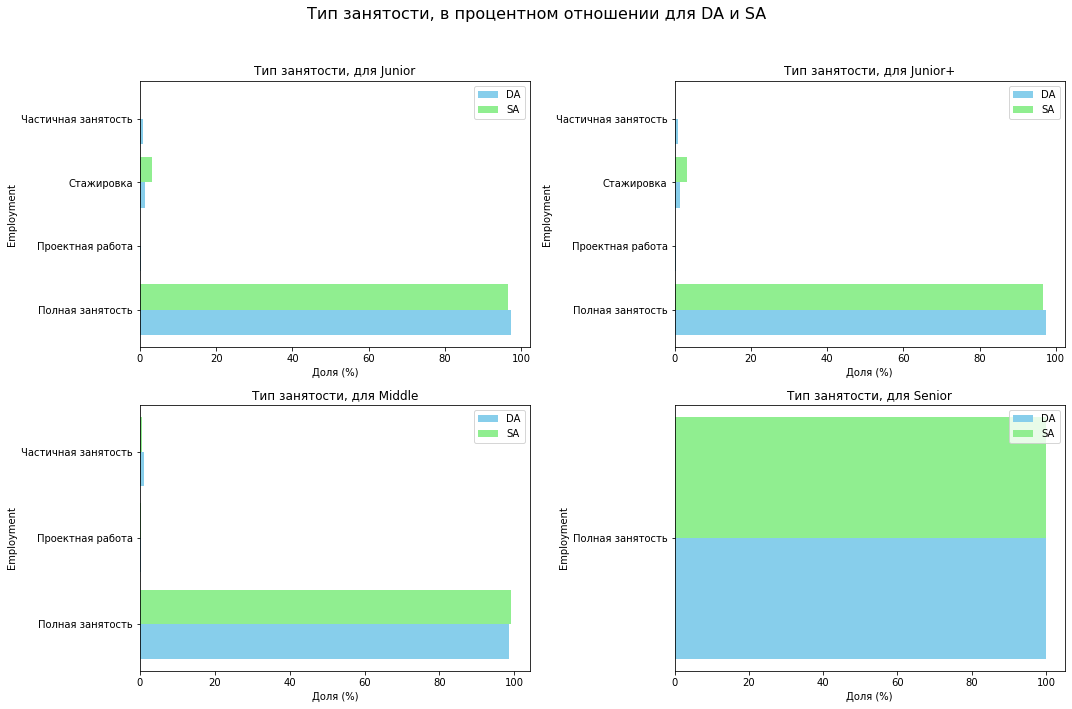

In [87]:
distribution(data, column='employment', title_prefix='Тип занятости,')

Логично, что стажировка встречается только для соискателей уровня junior и junior+, но даже среди них дол вакансий очень мала. Работодатели ждут от кандидатов полной занятости.

### Определение доли hard и soft навыков <a id='chapter9'></a>

In [90]:
# функция распределения упоминаний hard и soft навыков в вакансиях для дата аналитиков и системных аналитиков
def skill_distribution(data):

    # уровни грейдов и типы специалистов
    grades = ['Junior', 'Junior+', 'Middle', 'Senior']
    dataset_types = ['da', 'sa']
    
    # создаём сабплоты
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()

    for i, grade in enumerate(grades):
        for j, dataset_type in enumerate(dataset_types):
            # фильтруем данные по грейду и типу
            filtered_data = data[(data['experience'].str.contains(grade, na=False)) &
                                 (data['dataset_type'] == dataset_type)].copy()  # создадим копию среза
            
            # подсчёт навыков
            filtered_data.loc[:, 'hard_skill_count'] = filtered_data['hard_skills_from_description'].apply(
                lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
            filtered_data.loc[:, 'soft_skill_count'] = filtered_data['soft_skills_from_description'].apply(
                lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
            
            # суммарное количество навыков
            total_hard_skills = filtered_data['hard_skill_count'].sum()
            total_soft_skills = filtered_data['soft_skill_count'].sum()
            
            # данные для графика
            skill_types = ['hard Skills', 'soft Skills']
            counts = [total_hard_skills, total_soft_skills]
            
            # построение графика
            ax = axes[i * 2 + j]
            ax.bar(skill_types, counts, color=['skyblue', 'lightgreen'])
            ax.set_title(f'{grade} ({dataset_type.upper()})', fontsize=12)
            ax.set_ylabel('Количество упоминаний', fontsize=10)
            ax.set_xlabel('Тип навыка', fontsize=10)
            
            # добавление значений на столбцы
            for k, count in enumerate(counts):
                ax.text(k, count + 5, str(count), ha='center', fontsize=10)
    
    # оформление общего заголовока
    fig.suptitle('Количество упоминаний навыков для каждого грейда DA и SA', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


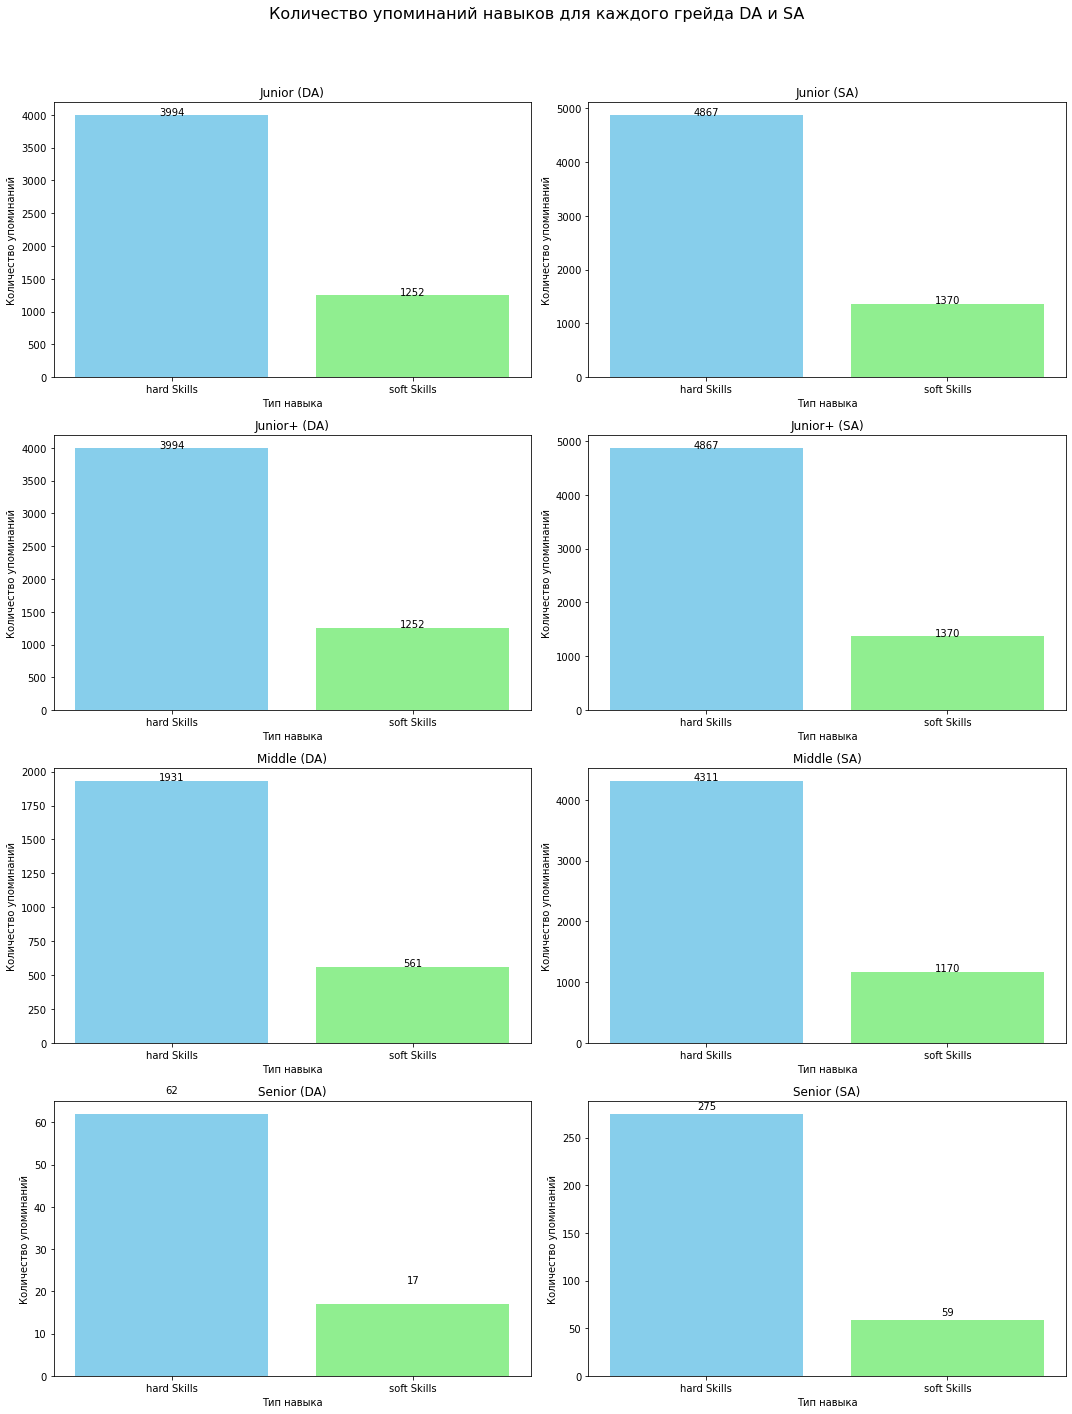

In [91]:
skill_distribution(data)


Можно сделать короткий вывод: софт навыки нужны, но по количеству упоминаний все же чаще от специалистов ждут хард скиллы.
Рассмотрим подробнее какие именно навыки ждут от кандидатов работодатели.

In [94]:
#для начала стандартизируем навыки и исключим те, где информация отсутствует
def clean_skills(skill_list):
    excluded_phrases = {"информация неизвестна"}  # список исключаемых значений
    return [skill.strip().lower() for skill in skill_list if skill.strip() and skill.strip().lower() not in excluded_phrases]

#визуализация самых часто встречающихся hard skills и soft skills
def top_skills(data, top_n=5):

    # уровни грейдов и типы специалистов
    grades = ['Junior', 'Junior+', 'Middle', 'Senior']
    dataset_types = ['da', 'sa']
    
    # создаём сабплоты
    fig, axes = plt.subplots(8, 2, figsize=(15, 40))  # 8 грейдов * 2 типа навыков (hard и soft)
    axes = axes.flatten()

    for i, grade in enumerate(grades):
        for j, dataset_type in enumerate(dataset_types):
            # фильтрация данных по грейду и типу
            filtered_data = data[(data['experience'].str.contains(grade, na=False)) &
                                 (data['dataset_type'] == dataset_type)].copy()
            
            # собираем hard skills и soft skills
            hard_skills = []
            soft_skills = []
            
            # добавляем навыки в списки
            filtered_data['hard_skills_from_description'].dropna().apply(
                lambda x: hard_skills.extend(clean_skills(str(x).split(','))))
            filtered_data['soft_skills_from_description'].dropna().apply(
                lambda x: soft_skills.extend(clean_skills(str(x).split(','))))
            
            # подсчитываем частоту навыков
            top_hard_skills = Counter(hard_skills).most_common(top_n)
            top_soft_skills = Counter(soft_skills).most_common(top_n)
            
            # разделяем навыки и их количество для построения графиков
            hard_skill_labels, hard_skill_counts = zip(*top_hard_skills) if top_hard_skills else ([], [])
            soft_skill_labels, soft_skill_counts = zip(*top_soft_skills) if top_soft_skills else ([], [])
            
            # инверсия порядка для сортировки от большего к меньшему
            hard_skill_labels = list(hard_skill_labels)[::-1]
            hard_skill_counts = list(hard_skill_counts)[::-1]
            soft_skill_labels = list(soft_skill_labels)[::-1]
            soft_skill_counts = list(soft_skill_counts)[::-1]
            
            # индексы сабплотов
            hard_ax = axes[i * 4 + j * 2]  # сабплот для hard skills
            soft_ax = axes[i * 4 + j * 2 + 1]  # сабплот для soft skills
            
            # построение графика для hard skills
            hard_ax.barh(hard_skill_labels, hard_skill_counts, color='skyblue')
            hard_ax.set_title(f'Топ {top_n} hard навыков ({grade}, {dataset_type.upper()})', fontsize=10)
            hard_ax.set_xlabel('Количество упоминаний', fontsize=8)
            hard_ax.set_ylabel('Навыки', fontsize=8)
            
            # построение графика для soft skills
            soft_ax.barh(soft_skill_labels, soft_skill_counts, color='lightgreen')
            soft_ax.set_title(f'Top {top_n} soft навыков ({grade}, {dataset_type.upper()})', fontsize=10)
            soft_ax.set_xlabel('Количество упоминаний', fontsize=8)
            soft_ax.set_ylabel('Навыки', fontsize=8)

    # общий заголовок
    fig.suptitle('Топ hard and soft навыков для каждого грейда и типа специалистов', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

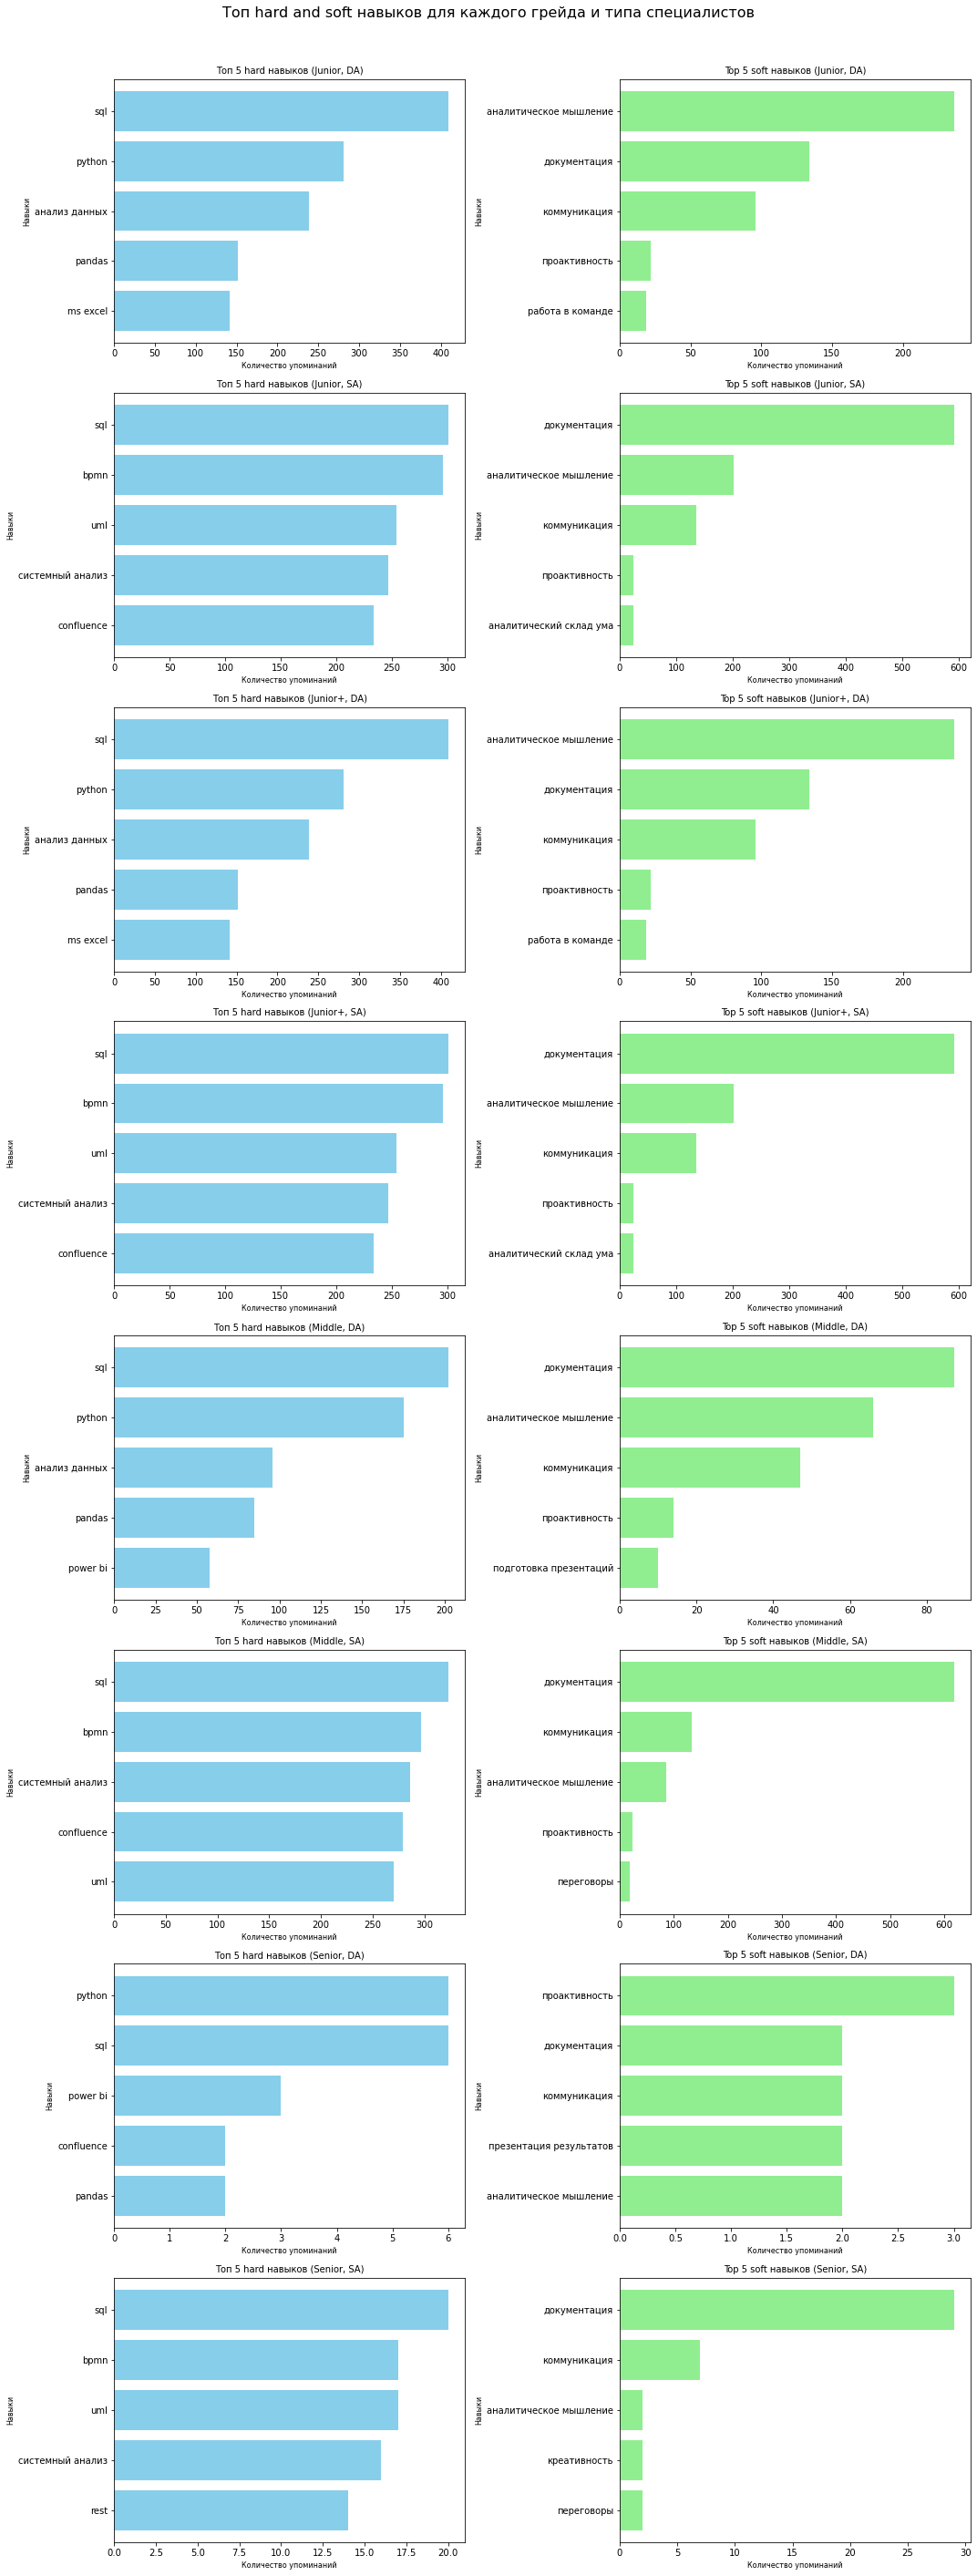

In [95]:
top_skills(data, top_n=5)

* Для junior и junior+ дата аналитиков чаще всего требуется знание sql, python и аналитическое мышление;
* Для всех грейдов системных аналитиков чаще всего требуется знание sql и bpmn, а из "мягких" навыков превалирует знание документации;
* Для middle дата аналитиков из  "твердых" навыков больше всего все также нужен sql и python, а вот топ soft skills немного меняется и на первое место выходит документация
* От специалистов с самым большим стажем среди дата аналитиков уже в равной степени ждут навыков в пайтон и sql среди hard навыков, а среди soft навыков на первый план выходит проактивность.

## Общий вывод и рекомендации <a id='chapter10'></a>


На основе анализа данных о вакансиях для аналитиков данных (Data Analysts, DA) и системных аналитиков (System Analysts, SA), можно сделать следующие выводы:    

**Распределение вакансий по грейдам:**   

Большинство вакансий приходится на уровни Junior и Junior+, что свидетельствует о высоком спросе на начинающих специалистов.    

**Условия труда:**    

Работодатели явно больше хотят видеть аналитиков всех уровней в офисе, которые работают полный рабочий день. Доля стажировок незначительно мала, а на удаленную работу могут рассчитывать только спецаилисты уровня middle и senior.
**Навыки:**   

Hard skills: SQL, Python, Excel и BI-инструменты остаются наиболее востребованными навыками для дата аналитиков. Для системных аналитиков акцент делается на документацию, моделирование процессов (UML, BPMN) и аналитическое мышление.
Soft skills: Среди наиболее важных навыков — аналитическое мышление, умение решать проблемы и коммуникативные способности. Они особенно ценятся для грейдов Middle и Senior.     
**Работодатели:**   

Крупные компании активно нанимают аналитиков всех уровней, но топовые работодатели отличаются для DA и SA. Это связано с особенностями задач и требований для каждой роли.

**Рекомендации для соискателей**   

* Для начинающих специалистов (Junior и Junior+):    

Сосредоточьтесь на изучении базовых технических навыков, таких как SQL, Excel, и основ программирования на Python. Эти навыки чаще всего требуют работодатели для начальных позиций.
Работайте над развитием аналитического мышления и навыков коммуникации, так как они являются основой для успешной работы в аналитике.    

* Для опытных специалистов (Middle и Senior):    

Расширяйте свои знания в области BI-инструментов (например, Power BI, Tableau) и работе с большими данными.
   * Для DA: уделите внимание углублению навыков программирования, анализу данных и работе с хранилищами данных.
   * Для SA: сосредоточьтесь на проектной документации, бизнес-анализе и моделировании процессов (UML, BPMN).    

* Учитывайте специфику работодателей:    

При поиске работы изучайте, какие навыки и опыт требуют разные компании. Это поможет вам лучше адаптировать своё резюме и выделиться среди других кандидатов.    


**Заключение**     
Этот анализ показывает, что рынок труда для аналитиков данных и системных аналитиков активно развивается. Для успешного трудоустройства необходимо не только владеть ключевыми техническими навыками, но и демонстрировать способность решать сложные задачи и работать в команде. Постоянное обучение и развитие в выбранной области помогут вам оставаться востребованным специалистом.